In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from plotnine import *
import pandas as pd
import re
import datetime as dt

In [2]:
orders = pd.read_csv("./data/Orders.csv")
returns = pd.read_csv("./data/Returns.csv")
orders.head()

,Row.ID,Order.ID,Order.Date,Ship.Date,Ship.Mode,Customer.ID,Customer.Name,Segment,Postal.Code,City,...,Product.ID,Category,Sub.Category,Product.Name,Sales,Quantity,Discount,Profit,Shipping.Cost,Order.Priority
0,40098,CA-2014-AB10015140-41954,11/11/14,11/13/14,First Class,AB-100151402,Aaron Bergman,Consumer,73120.0,Oklahoma City,...,TEC-PH-5816,Technology,Phones,Samsung Convoy 3,$221.98,2,0.0,$62.15,40.77,High
1,26341,IN-2014-JR162107-41675,2/5/14,2/7/14,Second Class,JR-162107,Justin Ritter,Corporate,NaN,Wollongong,...,FUR-CH-5379,Furniture,Chairs,"Novimex Executive Leather Armchair, Black","$3,709.40",9,0.1,-$288.77,923.63,Critical
2,25330,IN-2014-CR127307-41929,10/17/14,10/18/14,First Class,CR-127307,Craig Reiter,Consumer,NaN,Brisbane,...,TEC-PH-5356,Technology,Phones,"Nokia Smart Phone, with Caller ID","$5,175.17",9,0.1,$919.97,915.49,Medium
3,13524,ES-2014-KM1637548-41667,1/28/14,1/30/14,First Class,KM-1637548,Katherine Murray,Home Office,NaN,Berlin,...,TEC-PH-5267,Technology,Phones,"Motorola Smart Phone, Cordless","$2,892.51",5,0.1,-$96.54,910.16,Medium
4,47221,SG-2014-RH9495111-41948,11/5/14,11/6/14,Same Day,RH-9495111,Rick Hansen,Consumer,NaN,Dakar,...,TEC-CO-6011,Technology,Copiers,"Sharp Wireless Fax, High-Speed","$2,832.96",8,0.0,$311.52,903.04,Critical


## Part I
### Problem 1:
Profit and Sales of Orders

In [3]:
orders.Profit = orders.Profit.map(lambda x: re.sub("[$,]","",x)).astype(float)
orders.Sales = orders.Sales.map(lambda x: re.sub("[$,]","",x)).astype(float)

### Problem 2:
Seasonal trends trend in inventory and for different categories

In [4]:
orders["Order.Date"] = orders["Order.Date"].map(lambda x: dt.datetime.strptime(x,"%m/%d/%y"))
orders["Ship.Date"] = orders["Ship.Date"].map(lambda x: dt.datetime.strptime(x,"%m/%d/%y"))

In [5]:
seasonList = [1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 1]
seasonDict = dict(zip(range(1,13),seasonList))
nameDict = {1:"Winter",2:"Spring",3:"Summer",4:"Autumn"}
seasonDict = {i:nameDict[j] for i,j in seasonDict.items()}

In [6]:
orders["season"] = orders["Order.Date"].map(lambda x: seasonDict[x.month])

In [7]:
orders.groupby("season")["Quantity"].agg(["sum","mean","std"])

,sum,mean,std
season,,,
Autumn,59161,3.516256,2.267346
Spring,34052,3.465500,2.248999
Summer,46651,3.439832,2.289326
Winter,38448,3.470976,2.308539


Higher volumes in the summer and fall.

In [8]:
seasonFrame = orders.groupby(["Category","season"])["Quantity"].agg(["sum","mean","std"]).reset_index()
season_order = pd.api.types.CategoricalDtype(categories=["Winter","Spring","Summer","Autumn"], ordered=True)
seasonFrame["Season_ord"] = seasonFrame["season"].astype(season_order)

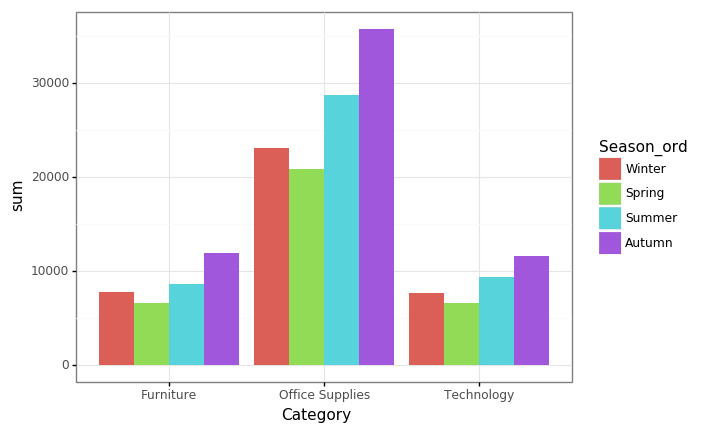

<ggplot: (-9223363297700302427)>

In [9]:
ggplot(seasonFrame,aes(x="Category",y="sum",group="Season_ord")) + geom_col(aes(fill="Season_ord"),position="dodge") +theme_bw()

All categories exhibit this trend but `Office Supplies` make up the bult of the business

### Problem 3:
Returns

In [10]:
returns.head()

,Returned,Order ID,Region
0,Yes,CA-2012-SA20830140-41210,Central US
1,Yes,IN-2012-PB19210127-41259,Eastern Asia
2,Yes,CA-2012-SC20095140-41174,Central US
3,Yes,IN-2015-JH158207-42140,Oceania
4,Yes,IN-2014-LC168857-41747,Oceania


In [112]:
returnDF = (orders.merge(returns,how="left",left_on="Order.ID",right_on="Order ID")
            .drop(columns=["Order ID","Region_y"])
            .rename(columns={"Region_x":"Region"})
                 )
returnDF.Returned = (returnDF.Returned == "Yes")
returnDF.sample(5)

,Row.ID,Order.ID,Order.Date,Ship.Date,Ship.Mode,Customer.ID,Customer.Name,Segment,Postal.Code,City,...,Sub.Category,Product.Name,Sales,Quantity,Discount,Profit,Shipping.Cost,Order.Priority,season,Returned
8476,18485,ES-2014-MM1726048-41813,2014-06-23,2014-06-28,Standard Class,MM-1726048,Magdelene Morse,Consumer,NaN,Berlin,...,Chairs,"SAFCO Swivel Stool, Adjustable",409.03,3,0.2,143.08,39.81,High,Summer,False
6589,33992,CA-2014-BE11410140-41677,2014-02-07,2014-02-09,First Class,BE-114101406,Bobby Elias,Consumer,43130.0,Lancaster,...,Paper,Xerox 1912,30.35,2,0.2,10.62,10.27,Critical,Winter,False
39350,24187,IN-2014-SC2002021-41948,2014-11-05,2014-11-10,Standard Class,SC-2002021,Sam Craven,Consumer,NaN,Phnom Penh,...,Labels,"Smead Round Labels, Alphabetical",20.16,3,0.0,1.17,2.40,Medium,Autumn,False
12692,46730,UP-2014-BT1680137-41948,2014-11-05,2014-11-07,First Class,BT-1680137,Brian Thompson,Consumer,NaN,Kirovohrad,...,Accessories,"Enermax Memory Card, Bluetooth",228.78,2,0.0,36.60,24.73,Medium,Autumn,False
10638,28457,IN-2012-JP1613527-41249,2012-12-06,2012-12-10,Standard Class,JP-1613527,Julie Prescott,Home Office,NaN,Shangzhi,...,Bookcases,"Bush Stackable Bookrack, Mobile",370.53,3,0.0,103.68,30.59,Medium,Winter,False


Total profil lost to returns:

In [24]:
returnDF[returnDF.Returned].Profit.sum()

61370.75

Number of customers with more than one return:

In [36]:
(returnDF[returnDF.Returned].groupby("Customer.ID").agg("count").reset_index().iloc[:,1] > 1).sum()

547

Number of customers with more than five returns:

In [105]:
(returnDF[returnDF.Returned].groupby("Customer.ID").agg("count").reset_index().iloc[:,1] > 5).sum()

2247

Central America and Western Europe make up a large quantity of returns
However proportionally Western US and East Asia are the greatest source of returns

In [114]:
returnDF.groupby("Region").Returned.agg("mean").sort_values(ascending=False)

Region
Western US           0.055261
Eastern Asia         0.055181
Southern Europe      0.053005
Southern Africa      0.052301
Southern US          0.051235
Eastern US           0.047051
Southeastern Asia    0.044743
South America        0.044511
Western Asia         0.044262
Oceania              0.044164
Central America      0.044160
Southern Asia        0.041808
Central Asia         0.041475
Western Africa       0.041096
Caribbean            0.040828
North Africa         0.039906
Western Europe       0.039606
Canada               0.039062
Northern Europe      0.034483
Central US           0.031855
Eastern Europe       0.027469
Central Africa       0.026439
Eastern Africa       0.024725
Name: Returned, dtype: float64

In [43]:
returnDF[returnDF.Returned].groupby("Region").agg("count").iloc[:,1].sort_values(ascending=False)

Region
Central America      248
Western Europe       233
Western US           180
Oceania              154
Southeastern Asia    140
Eastern US           134
South America        133
Eastern Asia         131
Southern Europe      112
Southern Asia        111
Western Asia         108
Southern US           83
Northern Europe       76
Central US            71
Caribbean             69
Western Africa        60
North Africa          51
Eastern Europe        42
Southern Africa       25
Eastern Africa        18
Central Africa        17
Eastern Canada        10
Central Asia           9
Western Canada         5
Name: Order.ID, dtype: int64

All categories are returned at the same rate but `Office Supplies` make up the bulk of returns due to making up a bulk of the orders

In [47]:
returnDF.groupby("Category").agg({"Returned":["mean","sum"]})

Returned        
                     mean     sum
Category                         
Furniture        0.043306   427.0
Office Supplies  0.043082  1348.0
Technology       0.043881   445.0

In [117]:
returnDF.groupby("Sub.Category").agg({"Returned":["mean","sum"]})

Returned       
                  mean    sum
Sub.Category                 
Accessories   0.044878  138.0
Appliances    0.033869   59.0
Art           0.044613  217.0
Binders       0.043768  269.0
Bookcases     0.043136  104.0
Chairs        0.042807  147.0
Copiers       0.044534   99.0
Envelopes     0.041475   99.0
Fasteners     0.039216  102.0
Furnishings   0.042803  135.0
Labels        0.052672  137.0
Machines      0.042396   63.0
Paper         0.042955  150.0
Phones        0.043193  145.0
Storage       0.041989  212.0
Supplies      0.042792  103.0
Tables        0.047619   41.0

## Part II 
### Problem 4:
Feature Engineering

In [50]:
returnDF["Process.Time"] = (returnDF["Ship.Date"] - returnDF["Order.Date"]).map(lambda x: x.days)

In [61]:
prodDict = returnDF.groupby("Product.ID").Returned.sum().astype(str)
prodMap = lambda x: prodDict.get(x,"0")

returnDF["Prod.Returns"] = returnDF["Product.ID"].map(prodMap)

### Problem 5:
Model fitting

In [65]:
df = returnDF.drop(columns=["Order.ID","Order.Date","Ship.Date","Row.ID","Customer.ID","Customer.Name","Postal.Code","City","Region"])

In [66]:
df.head()

,Ship.Mode,Segment,State,Country,Region_x,Market,Product.ID,Category,Sub.Category,Product.Name,Sales,Quantity,Discount,Profit,Shipping.Cost,Order.Priority,season,Returned,Process.Time,Prod.Returns
0,First Class,Consumer,Oklahoma,United States,Central US,USCA,TEC-PH-5816,Technology,Phones,Samsung Convoy 3,221.98,2,0.0,62.15,40.77,High,Autumn,False,2,0.0
1,Second Class,Corporate,New South Wales,Australia,Oceania,Asia Pacific,FUR-CH-5379,Furniture,Chairs,"Novimex Executive Leather Armchair, Black",3709.40,9,0.1,-288.77,923.63,Critical,Winter,False,2,2.0
2,First Class,Consumer,Queensland,Australia,Oceania,Asia Pacific,TEC-PH-5356,Technology,Phones,"Nokia Smart Phone, with Caller ID",5175.17,9,0.1,919.97,915.49,Medium,Autumn,False,1,2.0
3,First Class,Home Office,Berlin,Germany,Western Europe,Europe,TEC-PH-5267,Technology,Phones,"Motorola Smart Phone, Cordless",2892.51,5,0.1,-96.54,910.16,Medium,Winter,False,2,0.0
4,Same Day,Consumer,Dakar,Senegal,Western Africa,Africa,TEC-CO-6011,Technology,Copiers,"Sharp Wireless Fax, High-Speed",2832.96,8,0.0,311.52,903.04,Critical,Autumn,False,1,0.0


In [129]:
X = df.drop(columns=["Returned"])
y = df.Returned.astype(int)

The return rate is pretty low at 95.6%, we would need to train a model to have better accuracy than that to outdo the naive strategy

In [130]:
naive = 1-y.mean()
print(naive)

0.956716708910119


In [87]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss

In [135]:
oneHot = OneHotEncoder(handle_unknown="ignore")
oneHot = oneHot.fit(X)

In [142]:
print(oneHot.transform(X))

  (0, 0)	1.0
  (0, 4)	1.0
  (0, 761)	1.0
  (0, 1265)	1.0
  (0, 1279)	1.0
  (0, 1301)	1.0
  (0, 5040)	1.0
  (0, 5092)	1.0
  (0, 5106)	1.0
  (0, 8075)	1.0
  (0, 19645)	1.0
  (0, 28948)	1.0
  (0, 28961)	1.0
  (0, 40112)	1.0
  (0, 55361)	1.0
  (0, 62019)	1.0
  (0, 62022)	1.0
  (0, 62028)	1.0
  (0, 62034)	1.0
  (1, 2)	1.0
  (1, 5)	1.0
  (1, 716)	1.0
  (1, 1115)	1.0
  (1, 1286)	1.0
  (1, 1298)	1.0
  :	:
  (51288, 35840)	1.0
  (51288, 45567)	1.0
  (51288, 62021)	1.0
  (51288, 62025)	1.0
  (51288, 62030)	1.0
  (51288, 62037)	1.0
  (51289, 2)	1.0
  (51289, 4)	1.0
  (51289, 613)	1.0
  (51289, 1214)	1.0
  (51289, 1277)	1.0
  (51289, 1300)	1.0
  (51289, 3453)	1.0
  (51289, 5091)	1.0
  (51289, 5105)	1.0
  (51289, 6253)	1.0
  (51289, 13524)	1.0
  (51289, 28949)	1.0
  (51289, 28961)	1.0
  (51289, 35780)	1.0
  (51289, 45566)	1.0
  (51289, 62019)	1.0
  (51289, 62023)	1.0
  (51289, 62030)	1.0
  (51289, 62034)	1.0


In [83]:
folds = StratifiedKFold(shuffle=True,n_splits=5,random_state=6)

Use recall as a relevant metric

In [125]:
np.array([1,2,3]).mean()

2.0

In [ ]:
#### NEED TO FIX ONE HOT ENCODER

In [127]:
Cvec = np.logspace(-2,5,20)
l1vec  = np.linspace(0,1,10)

# need a better name for this
vals = []
for C in Cvec:
    scores = np.array([])
    loss = np.array([])
    for train_Idx, test_Idx in folds.split(X,y):
        logClass = LogisticRegression(solver="lbfgs",C=C)
        train_X,test_X,train_y,test_y = X[train_Idx], X[test_Idx], y[train_Idx], y[test_Idx]
        logClass.fit(train_X,train_y)
        scores = np.append(scores,logClass.score(test_X,test_y))
        loss = np.append(loss,log_loss(test_y,logClass.predict(test_X)))
    vals.append({"C":C, "score":scores.mean(),"loss":loss.mean()})

/home/alex/anaconda3/envs/nycdsa/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/alex/anaconda3/envs/nycdsa/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/alex/anaconda3/envs/nycdsa/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/alex/anaconda3/envs/nycdsa/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/alex/anaconda3/envs/nycdsa/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: l

KeyboardInterrupt: 

In [89]:
returnDF[returnDF.Returned]

,Row.ID,Order.ID,Order.Date,Ship.Date,Ship.Mode,Customer.ID,Customer.Name,Segment,Postal.Code,City,...,Quantity,Discount,Profit,Shipping.Cost,Order.Priority,season,Returned,Region,Process.Time,Prod.Returns
26,30191,IN-2012-PB19210127-41259,2012-12-16,2012-12-19,First Class,PB-19210127,Phillip Breyer,Corporate,NaN,Taipei,...,2,0.00,720.36,725.570,Critical,Winter,True,Eastern Asia,3,1.0
53,30190,IN-2012-PB19210127-41259,2012-12-16,2012-12-19,First Class,PB-19210127,Phillip Breyer,Corporate,NaN,Taipei,...,5,0.00,153.75,627.270,Critical,Winter,True,Eastern Asia,3,2.0
75,25438,IN-2015-JH158207-42140,2015-05-16,2015-05-18,Second Class,JH-158207,John Huston,Consumer,NaN,Melbourne,...,5,0.10,858.90,581.880,Critical,Spring,True,Oceania,2,2.0
110,32648,CA-2014-AS10045140-41727,2014-03-29,2014-04-01,First Class,AS-100451408,Aaron Smayling,Corporate,22204.0,Arlington,...,2,0.00,7.85,3.810,Medium,Spring,True,Southern US,3,2.0
113,29629,IN-2014-LC168857-41747,2014-04-18,2014-04-19,First Class,LC-168857,Lena Creighton,Consumer,NaN,Sydney,...,5,0.10,587.19,511.470,Critical,Spring,True,Oceania,1,1.0
137,30267,ID-2013-AB1001527-41439,2013-06-14,2013-06-17,First Class,AB-1001527,Aaron Bergman,Consumer,NaN,Wuhan,...,8,0.50,-286.92,487.320,Critical,Summer,True,Eastern Asia,3,2.0
151,15162,ES-2015-RA1994545-42218,2015-08-02,2015-08-03,First Class,RA-1994545,Ryan Akin,Consumer,NaN,Le Petit-Quevilly,...,3,0.10,296.66,472.000,Critical,Summer,True,Western Europe,1,2.0
163,30187,IN-2012-PB19210127-41259,2012-12-16,2012-12-19,First Class,PB-19210127,Phillip Breyer,Corporate,NaN,Taipei,...,3,0.00,311.85,458.970,Critical,Winter,True,Eastern Asia,3,1.0
178,18990,ES-2014-JF15295120-41924,2014-10-12,2014-10-12,Same Day,JF-15295120,Jason Fortune-,Consumer,NaN,Valencia,...,6,0.00,139.32,443.920,Critical,Autumn,True,Southern Europe,0,1.0
200,24361,IN-2014-NM1844527-41800,2014-06-10,2014-06-10,Same Day,NM-1844527,Nathan Mautz,Home Office,NaN,Shenzhen,...,4,0.00,0.00,427.100,Critical,Summer,True,Eastern Asia,0,2.0
